# Optimal Transport on 3D Mesh Graphs

This notebook demonstrates the Flow Sinkhorn algorithm applied to the graph defined by the edges of a 3D triangular mesh.

We will:
1. Load a 3D mesh from an OFF file
2. Visualize the mesh and its vertices
3. Select source vertices (top) and sink vertices (bottom)
4. Compute exact optimal transport using linear programming
5. Compute approximate transport using Flow Sinkhorn with different regularization levels
6. Visualize the flow on the mesh edges

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys
import time
import warnings

# Add parent directory to path
sys.path.insert(0, '..')

# Import Flow Sinkhorn toolbox
from flowsinkhorn import sinkhorn_w1_sparse, solve_w1_exact
import sparse

warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Load 3D Mesh from OFF File

The OFF (Object File Format) is a simple format for storing 3D geometry:
- First line: "OFF"
- Second line: number of vertices, number of faces, number of edges
- Next lines: vertex coordinates (x, y, z)
- Remaining lines: face vertex indices

## 2. Build Graph from Mesh Edges

We construct an undirected graph where:
- Nodes are mesh vertices
- Edges connect vertices that share a face
- Edge weights are Euclidean distances

## 3. Visualize the 3D Mesh

Display the mesh with vertices highlighted.

## 4. Select Source and Sink Vertices

We select:
- **Sources** (red): k vertices with highest z-coordinate (top of mesh)
- **Sinks** (blue): k vertices with lowest z-coordinate (bottom of mesh)

## 5. Exact Optimal Transport (Linear Programming)

Compute the exact optimal transport using CVXPY.

This solves:
$$
\min_{F \geq 0} \langle F, W \rangle \quad \text{s.t.} \quad F^\top \mathbf{1} - F \mathbf{1} = z
$$

In [7]:
print("Computing exact optimal transport...")
start = time.time()
F_exact, obj_exact, status = solve_w1_exact(W, z, verbose=False)
time_exact = time.time() - start

print(f"Exact solver:")
print(f"  - Status: {status}")
print(f"  - Optimal cost: {obj_exact:.6f}")
print(f"  - Time: {time_exact:.2f}s")
print(f"  - Non-zero flows: {np.sum(F_exact > 1e-6)}")

Computing exact optimal transport...
Exact solver:
  - Status: optimal
  - Optimal cost: 37.871791
  - Time: 16.23s
  - Non-zero flows: 1083


### Visualize Exact Flow

Display edges with significant flow.

## 6. Flow Sinkhorn with Large Regularization

First, we use a large entropic regularization parameter $\varepsilon$ for a smoother, more diffuse flow.

In [9]:
# Create sparse cost matrix
Ws = sparse.COO(A.nonzero(), W[A.nonzero()], shape=W.shape, fill_value=1e9)

# Large regularization
epsilon_large = 0.1
niter = 3000

print(f"Computing Sinkhorn flow with large regularization (ε = {epsilon_large})...")
start = time.time()
F_sinkhorn_large, err_large, h_large = sinkhorn_w1_sparse(Ws, z, epsilon=epsilon_large, niter=niter)
time_sinkhorn_large = time.time() - start

# Convert to dense for visualization
F_sinkhorn_large_dense = F_sinkhorn_large.todense()

# Compute cost
cost_large = np.sum(F_sinkhorn_large_dense * W)

print(f"Sinkhorn (large ε):")
print(f"  - Final error: {err_large[-1]:.2e}")
print(f"  - Cost: {cost_large:.6f}")
print(f"  - Relative cost error: {abs(cost_large - obj_exact) / obj_exact * 100:.2f}%")
print(f"  - Time: {time_sinkhorn_large:.2f}s")
print(f"  - Speedup vs exact: {time_exact / time_sinkhorn_large:.1f}x")

Computing Sinkhorn flow with large regularization (ε = 0.1)...
Sinkhorn (large ε):
  - Final error: 8.01e-07
  - Cost: 38.199986
  - Relative cost error: 0.87%
  - Time: 12.67s
  - Speedup vs exact: 1.3x


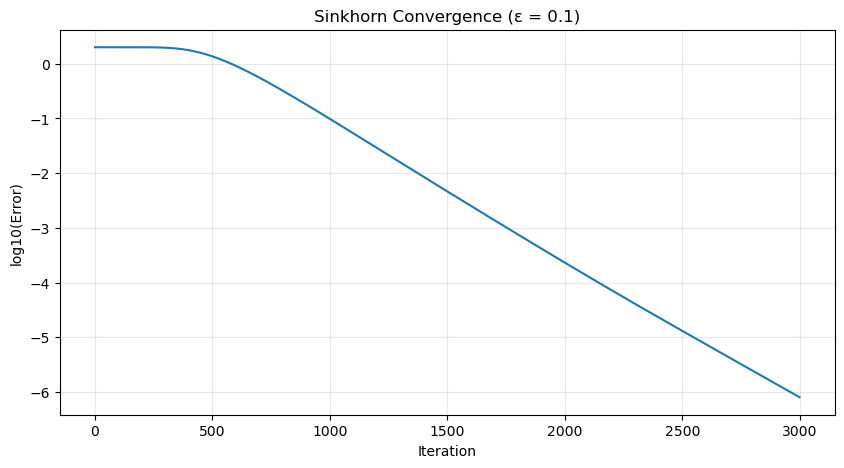

In [10]:
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(np.log10(err_large))
plt.xlabel('Iteration')
plt.ylabel('log10(Error)')
plt.title(f'Sinkhorn Convergence (ε = {epsilon_large})')
plt.grid(True, alpha=0.3)
plt.show()

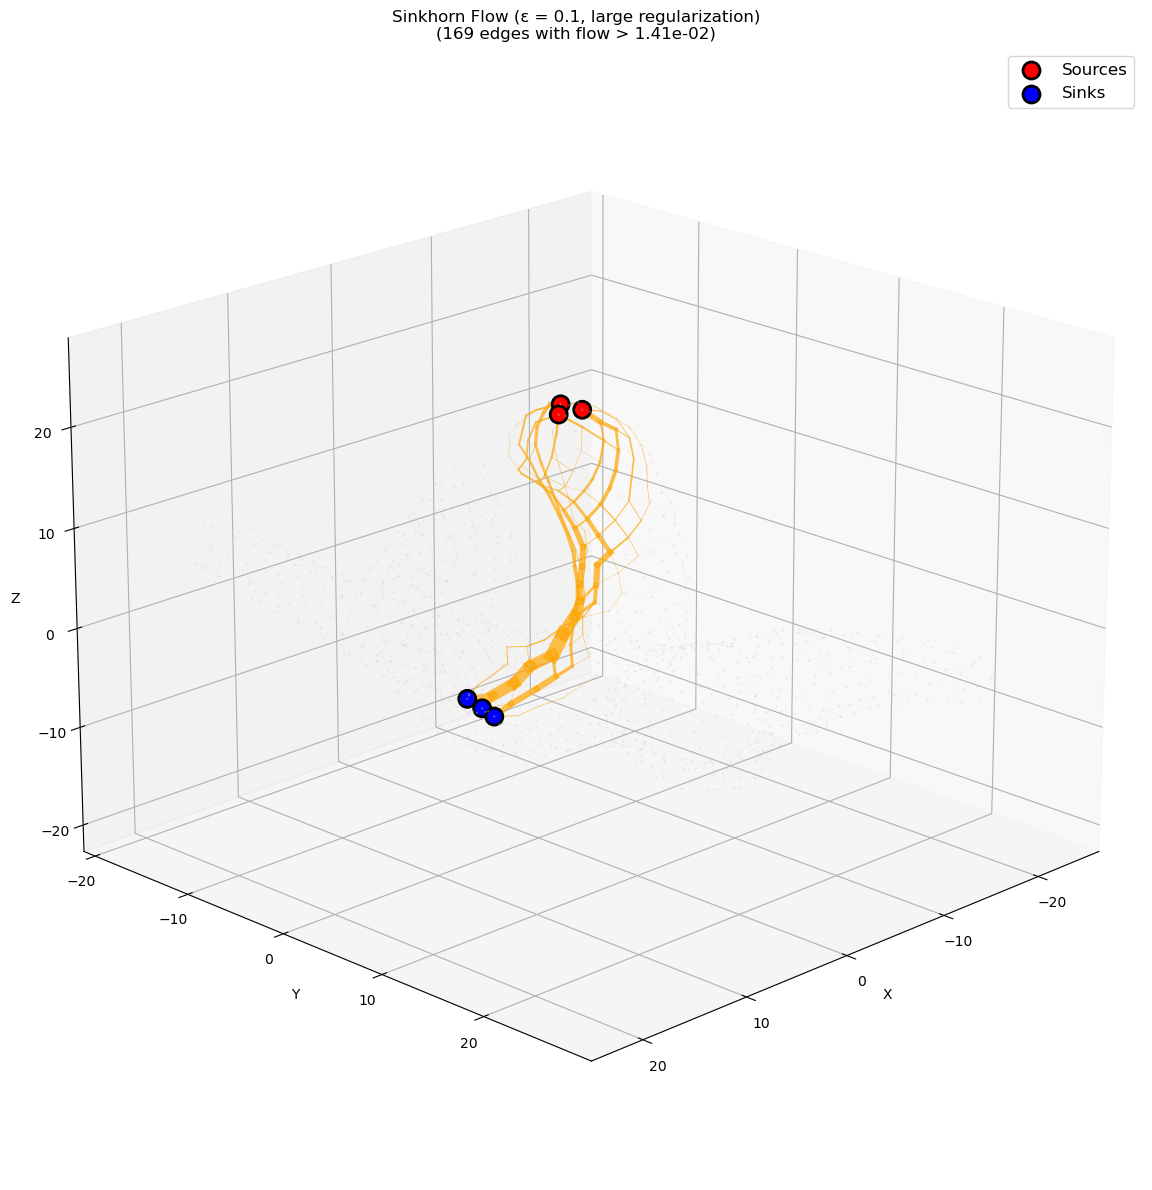

In [11]:
# Visualize flow
threshold_large = F_sinkhorn_large_dense.max() / 50
plot_mesh_with_flow(vertices, faces, F_sinkhorn_large_dense, z,
                    threshold=threshold_large,
                    title=f"Sinkhorn Flow (ε = {epsilon_large}, large regularization)",
                    flow_color='orange',
                    flow_width_scale=10)

## 7. Flow Sinkhorn with Small Regularization

Now we use a smaller $\varepsilon$ to get closer to the exact solution.

In [14]:
# Small regularization
epsilon_small = 0.03
niter = 5000

print(f"Computing Sinkhorn flow with small regularization (ε = {epsilon_small})...")
start = time.time()
F_sinkhorn_small, err_small, h_small = sinkhorn_w1_sparse(Ws, z, epsilon=epsilon_small, niter=niter)
time_sinkhorn_small = time.time() - start

# Convert to dense
F_sinkhorn_small_dense = F_sinkhorn_small.todense()

# Compute cost
cost_small = np.sum(F_sinkhorn_small_dense * W)

print(f"Sinkhorn (small ε):")
print(f"  - Final error: {err_small[-1]:.2e}")
print(f"  - Cost: {cost_small:.6f}")
print(f"  - Relative cost error: {abs(cost_small - obj_exact) / obj_exact * 100:.2f}%")
print(f"  - Time: {time_sinkhorn_small:.2f}s")
print(f"  - Speedup vs exact: {time_exact / time_sinkhorn_small:.1f}x")

Computing Sinkhorn flow with small regularization (ε = 0.03)...
Sinkhorn (small ε):
  - Final error: 1.11e-09
  - Cost: 37.360394
  - Relative cost error: 1.35%
  - Time: 18.60s
  - Speedup vs exact: 0.9x


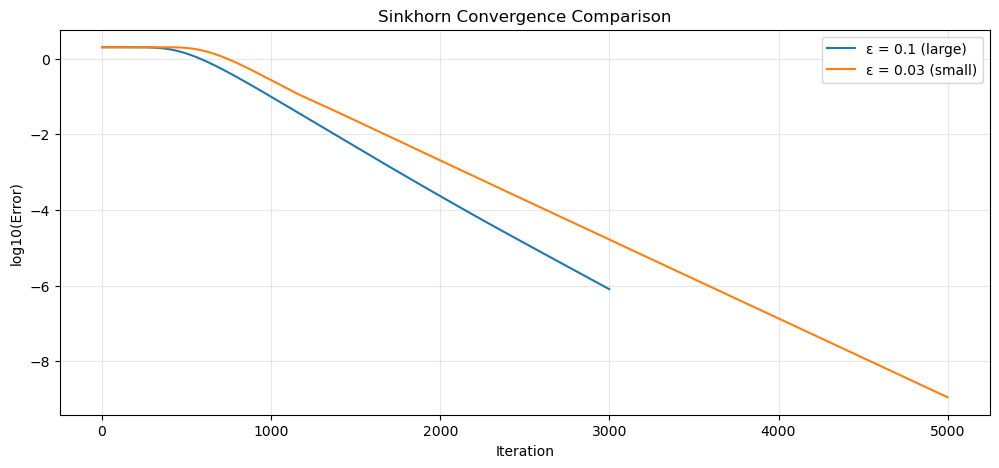

In [15]:
# Plot convergence comparison
plt.figure(figsize=(12, 5))
plt.plot(np.log10(err_large), label=f'ε = {epsilon_large} (large)')
plt.plot(np.log10(err_small), label=f'ε = {epsilon_small} (small)')
plt.xlabel('Iteration')
plt.ylabel('log10(Error)')
plt.title('Sinkhorn Convergence Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

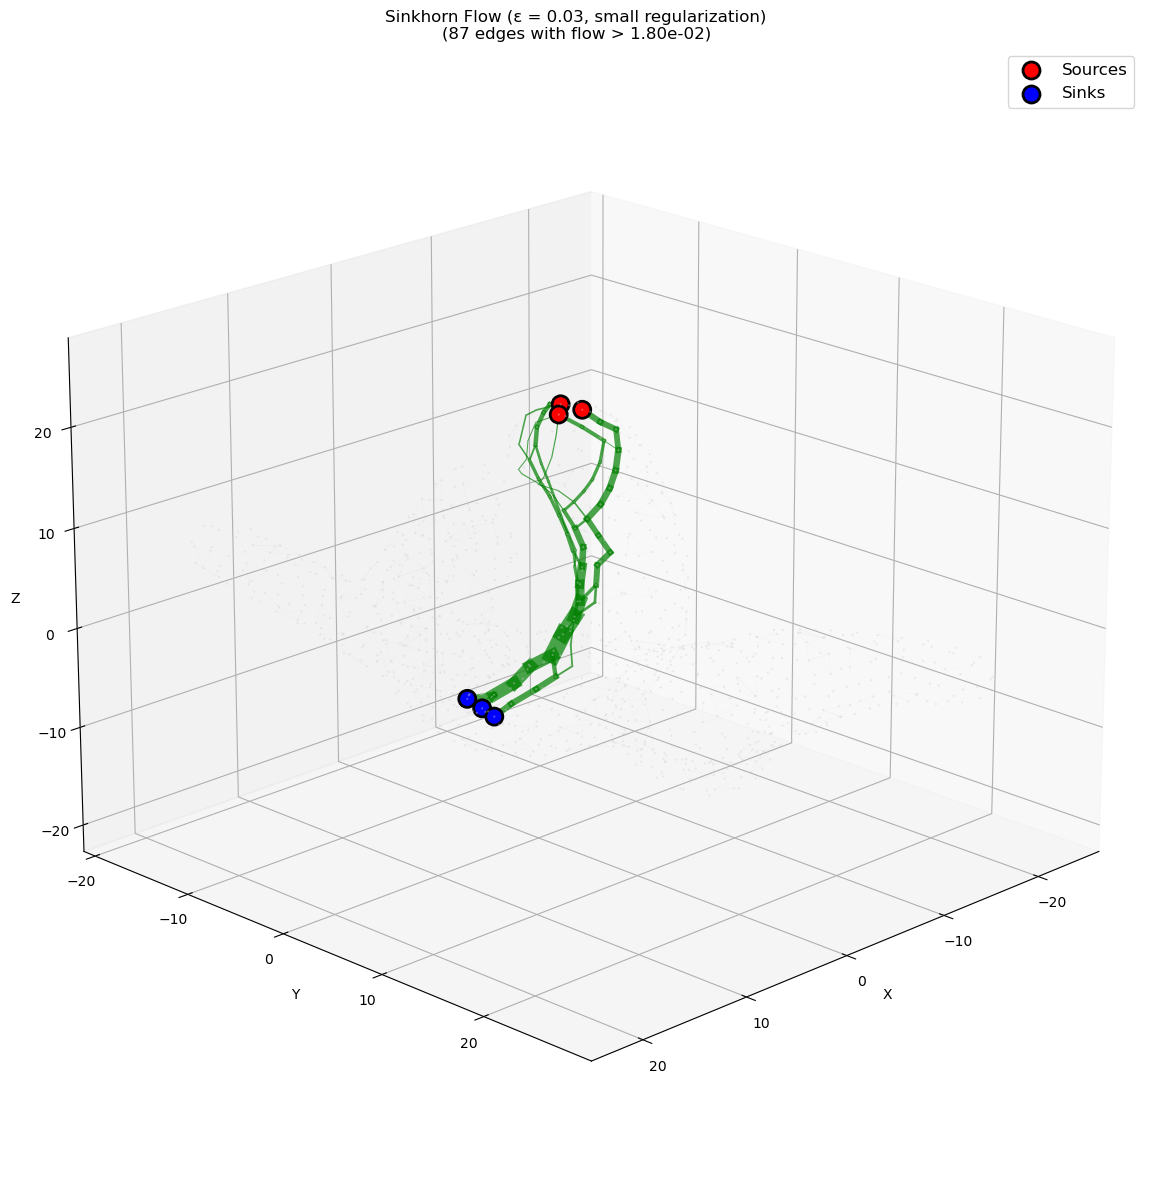

In [16]:
# Visualize flow
threshold_small = F_sinkhorn_small_dense.max() / 50
plot_mesh_with_flow(vertices, faces, F_sinkhorn_small_dense, z,
                    threshold=threshold_small,
                    title=f"Sinkhorn Flow (ε = {epsilon_small}, small regularization)",
                    flow_color='green',
                    flow_width_scale=12)

## 8. Comparison Summary

Compare all three methods: exact, large regularization, and small regularization.


COMPARISON SUMMARY
Method                            Cost   Rel. Error   Time (s)  Speedup
----------------------------------------------------------------------
Exact (CVXPY)                37.871791        0.00%      16.23     1.0x
Sinkhorn (ε=0.1)             38.199986        0.87%      12.67     1.3x
Sinkhorn (ε=0.03)            37.360394        1.35%      18.60     0.9x


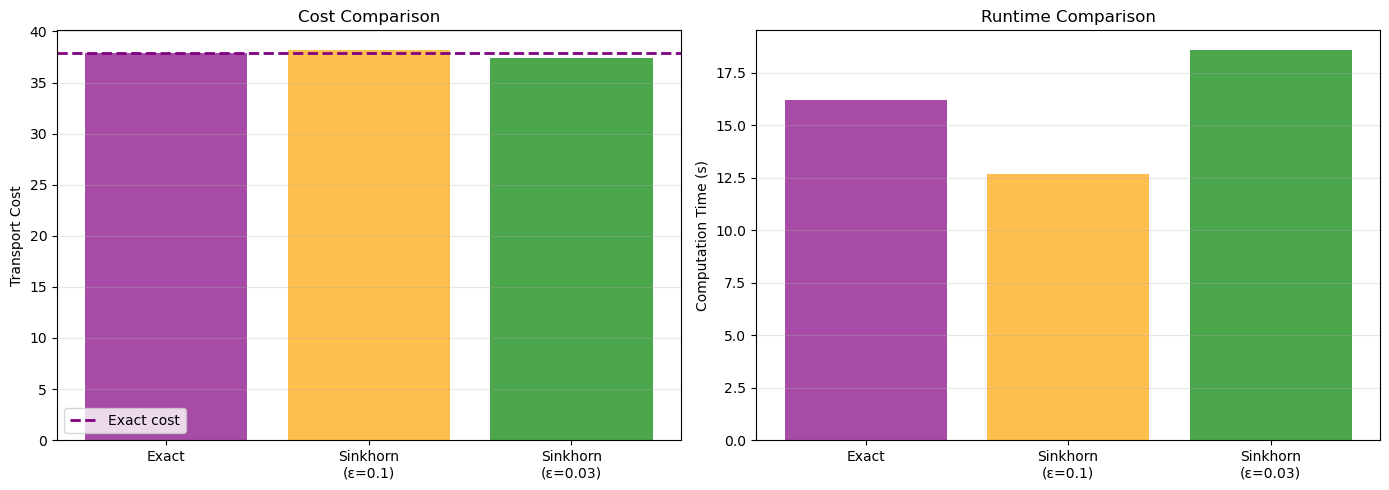

In [17]:
# Summary table
print("\n" + "="*70)
print("COMPARISON SUMMARY")
print("="*70)
print(f"{'Method':<25} {'Cost':>12} {'Rel. Error':>12} {'Time (s)':>10} {'Speedup':>8}")
print("-"*70)
print(f"{'Exact (CVXPY)':<25} {obj_exact:>12.6f} {0.0:>11.2f}% {time_exact:>10.2f} {'1.0x':>8}")
print(f"{'Sinkhorn (ε=' + str(epsilon_large) + ')':<25} {cost_large:>12.6f} "
      f"{abs(cost_large - obj_exact) / obj_exact * 100:>11.2f}% "
      f"{time_sinkhorn_large:>10.2f} {time_exact / time_sinkhorn_large:>7.1f}x")
print(f"{'Sinkhorn (ε=' + str(epsilon_small) + ')':<25} {cost_small:>12.6f} "
      f"{abs(cost_small - obj_exact) / obj_exact * 100:>11.2f}% "
      f"{time_sinkhorn_small:>10.2f} {time_exact / time_sinkhorn_small:>7.1f}x")
print("="*70)

# Bar plot of costs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

methods = ['Exact', f'Sinkhorn\n(ε={epsilon_large})', f'Sinkhorn\n(ε={epsilon_small})']
costs = [obj_exact, cost_large, cost_small]
times = [time_exact, time_sinkhorn_large, time_sinkhorn_small]

# Cost comparison
colors = ['purple', 'orange', 'green']
ax1.bar(methods, costs, color=colors, alpha=0.7)
ax1.axhline(y=obj_exact, color='purple', linestyle='--', linewidth=2, label='Exact cost')
ax1.set_ylabel('Transport Cost')
ax1.set_title('Cost Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Time comparison
ax2.bar(methods, times, color=colors, alpha=0.7)
ax2.set_ylabel('Computation Time (s)')
ax2.set_title('Runtime Comparison')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Side-by-Side Visualization

Display all three solutions from different viewing angles.


Viewing angle: elevation=20°, azimuth=45°


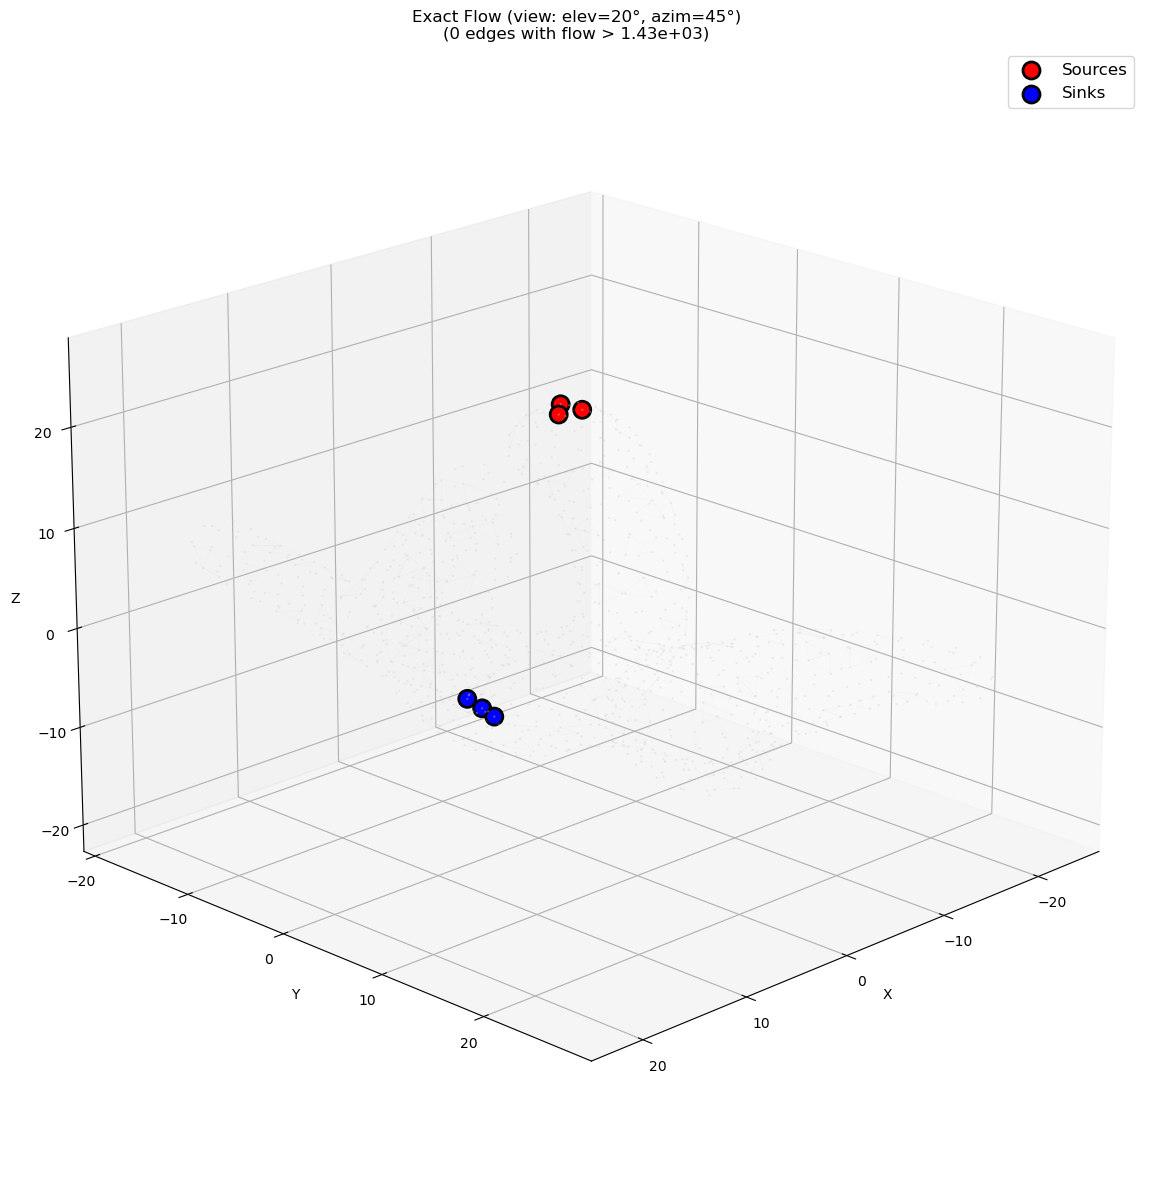

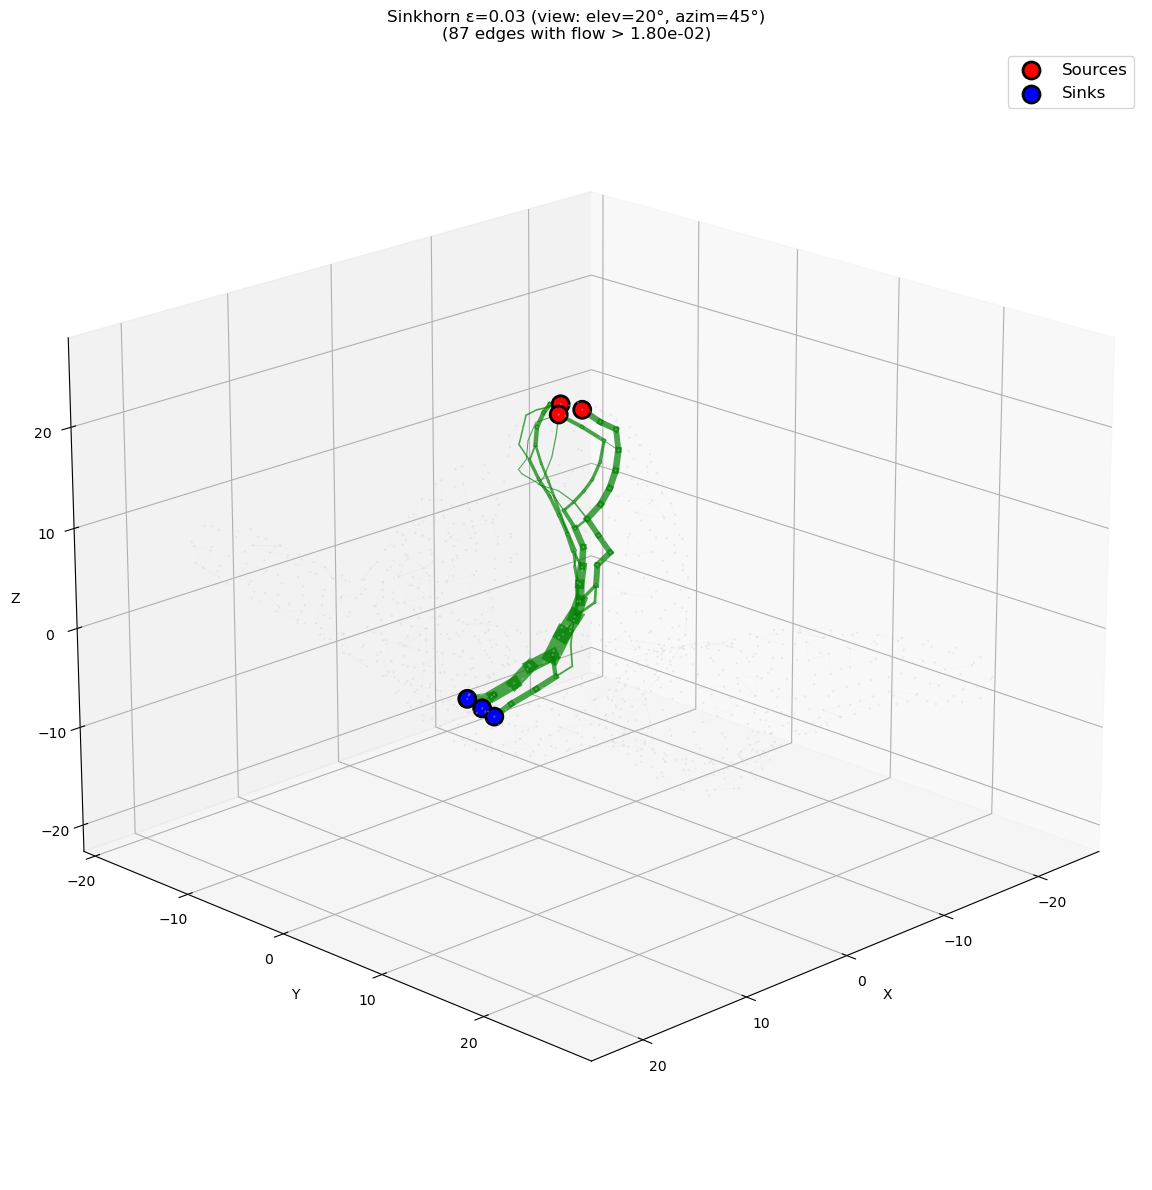


Viewing angle: elevation=20°, azimuth=135°


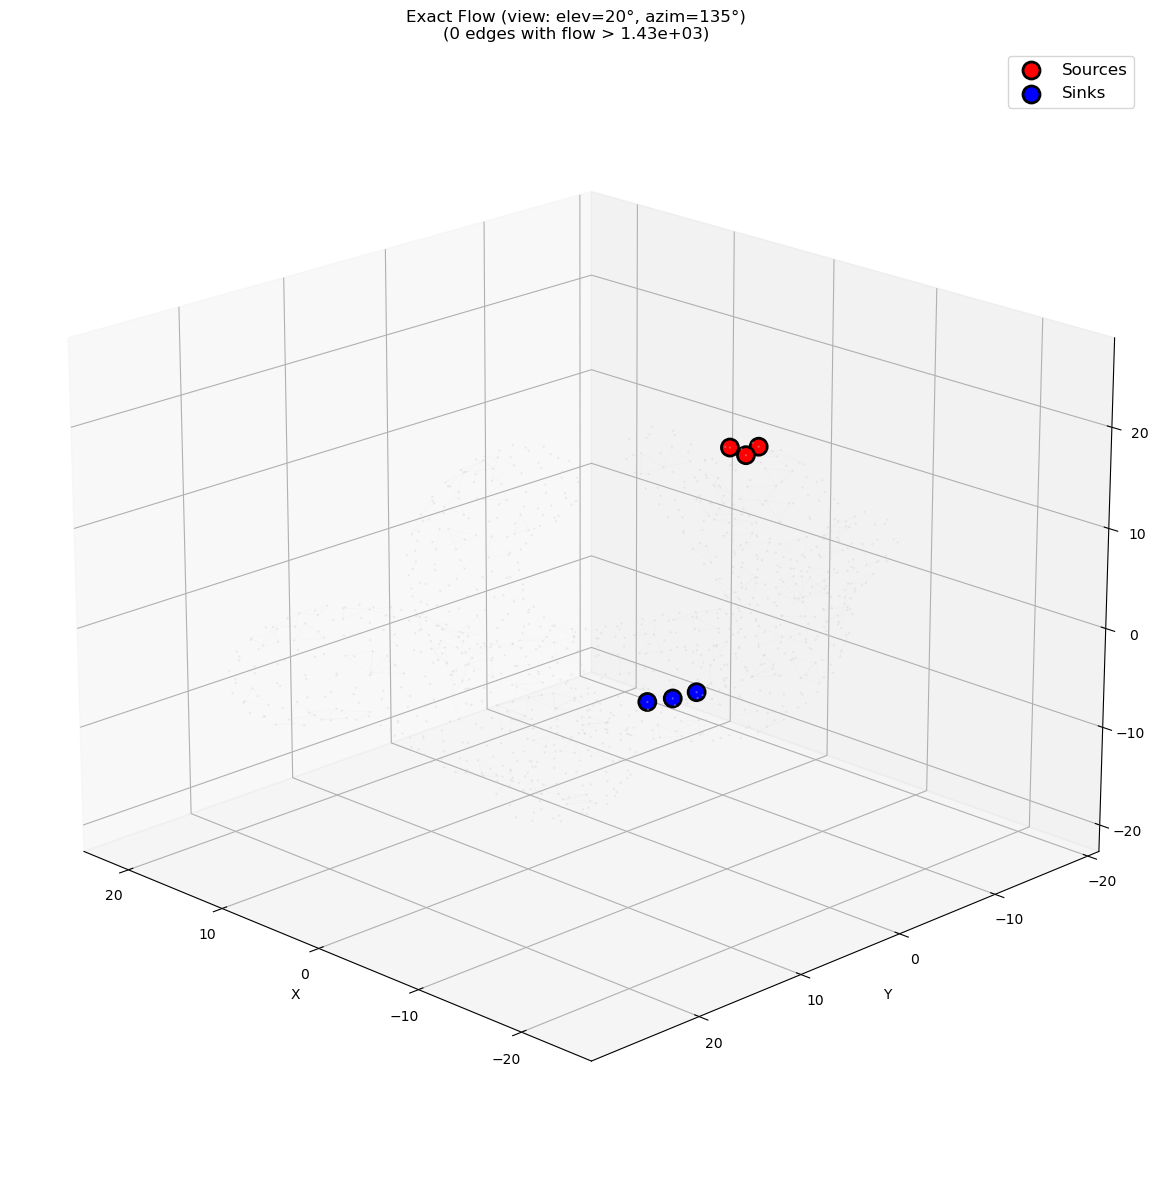

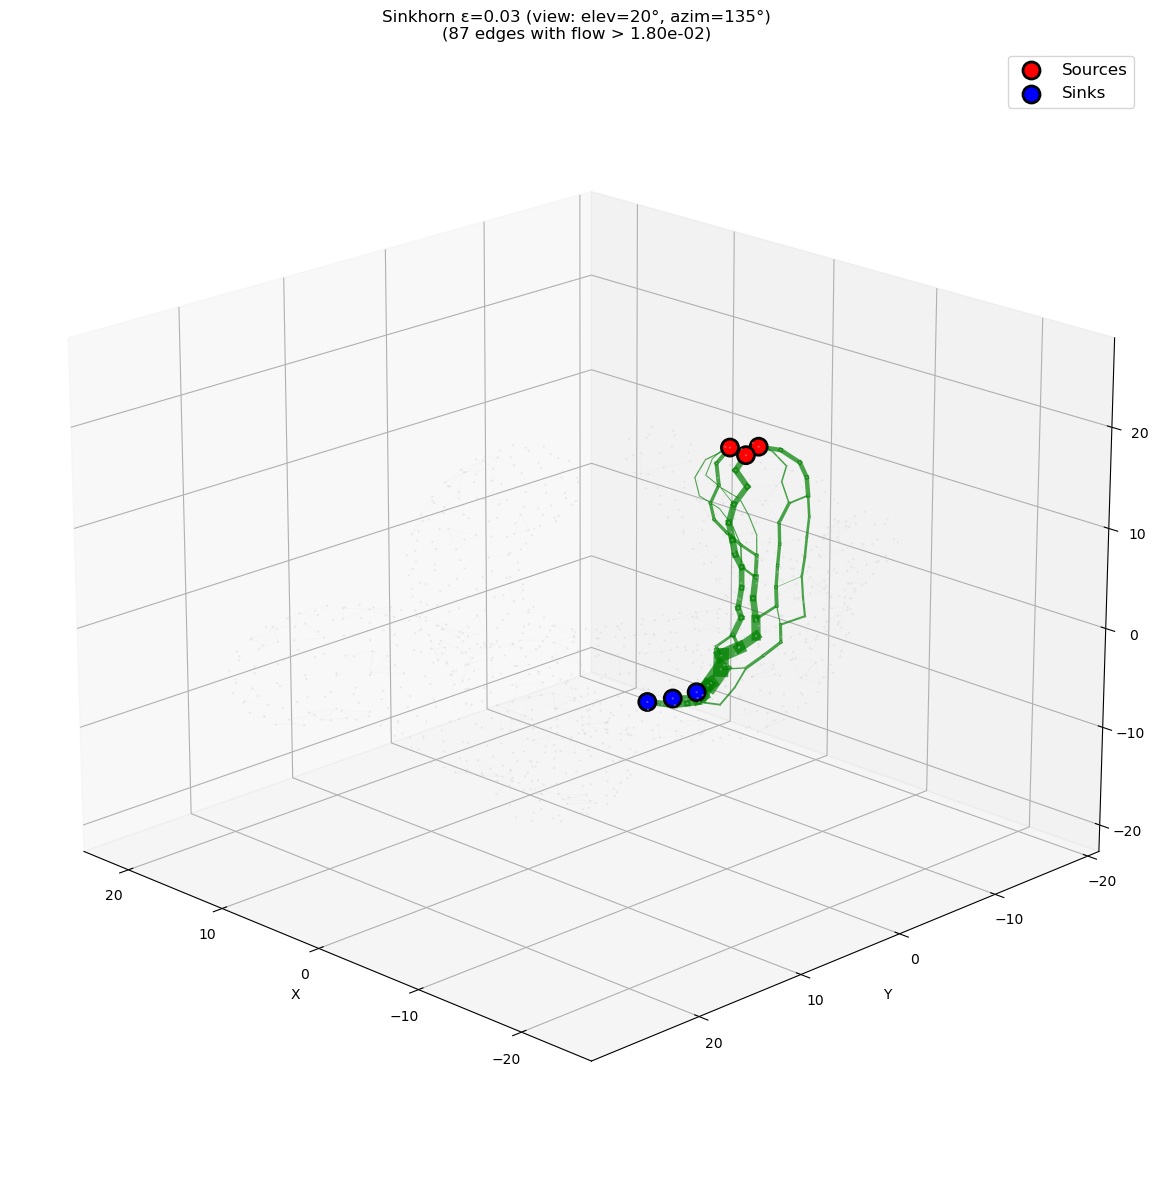


Viewing angle: elevation=60°, azimuth=45°


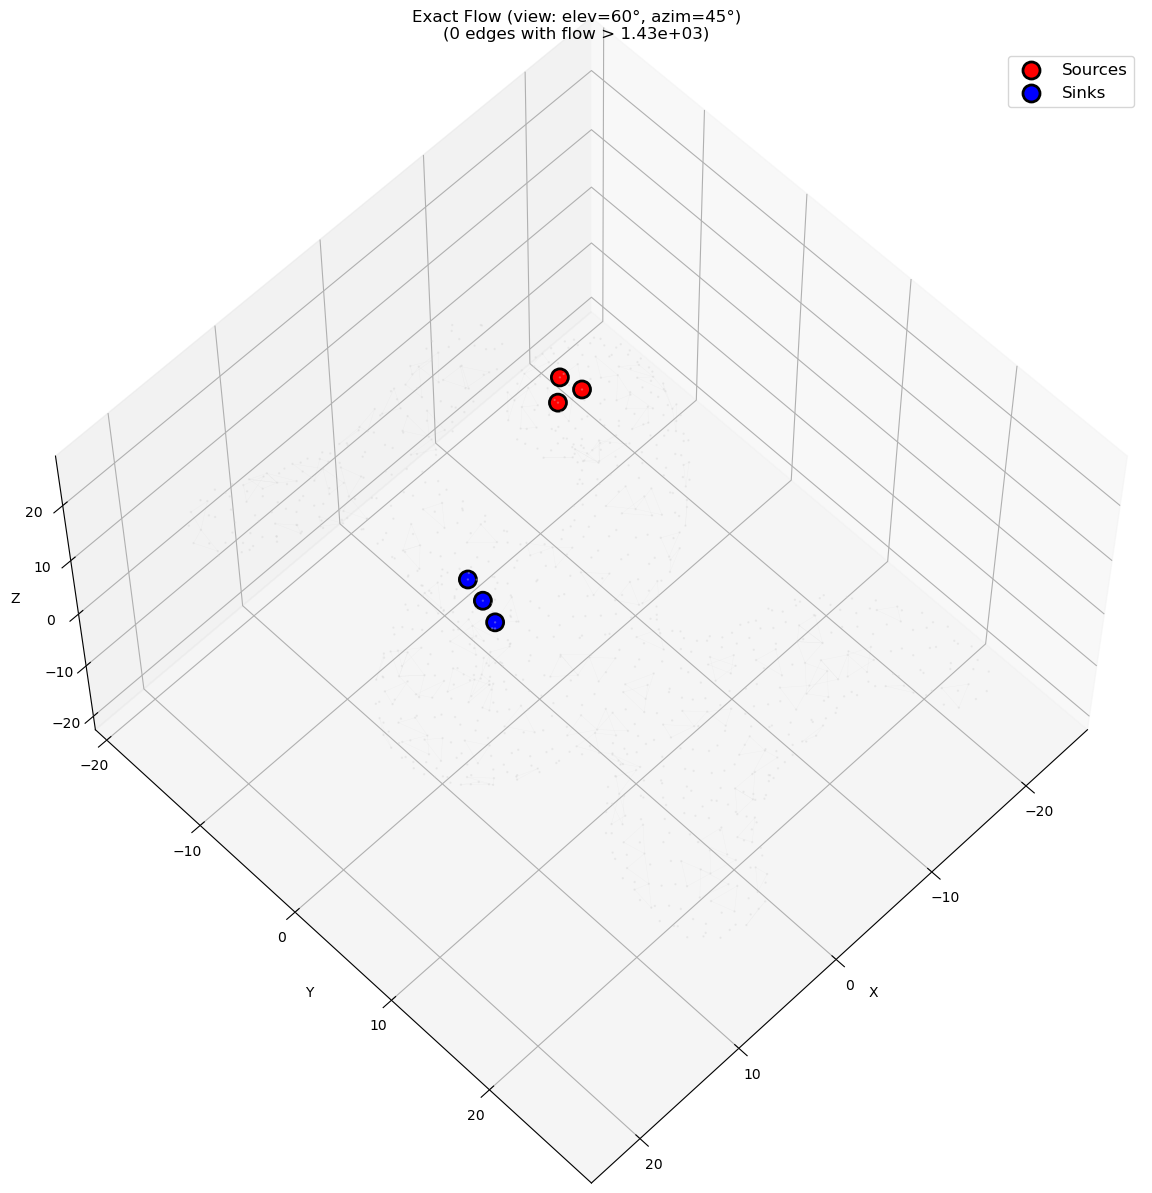

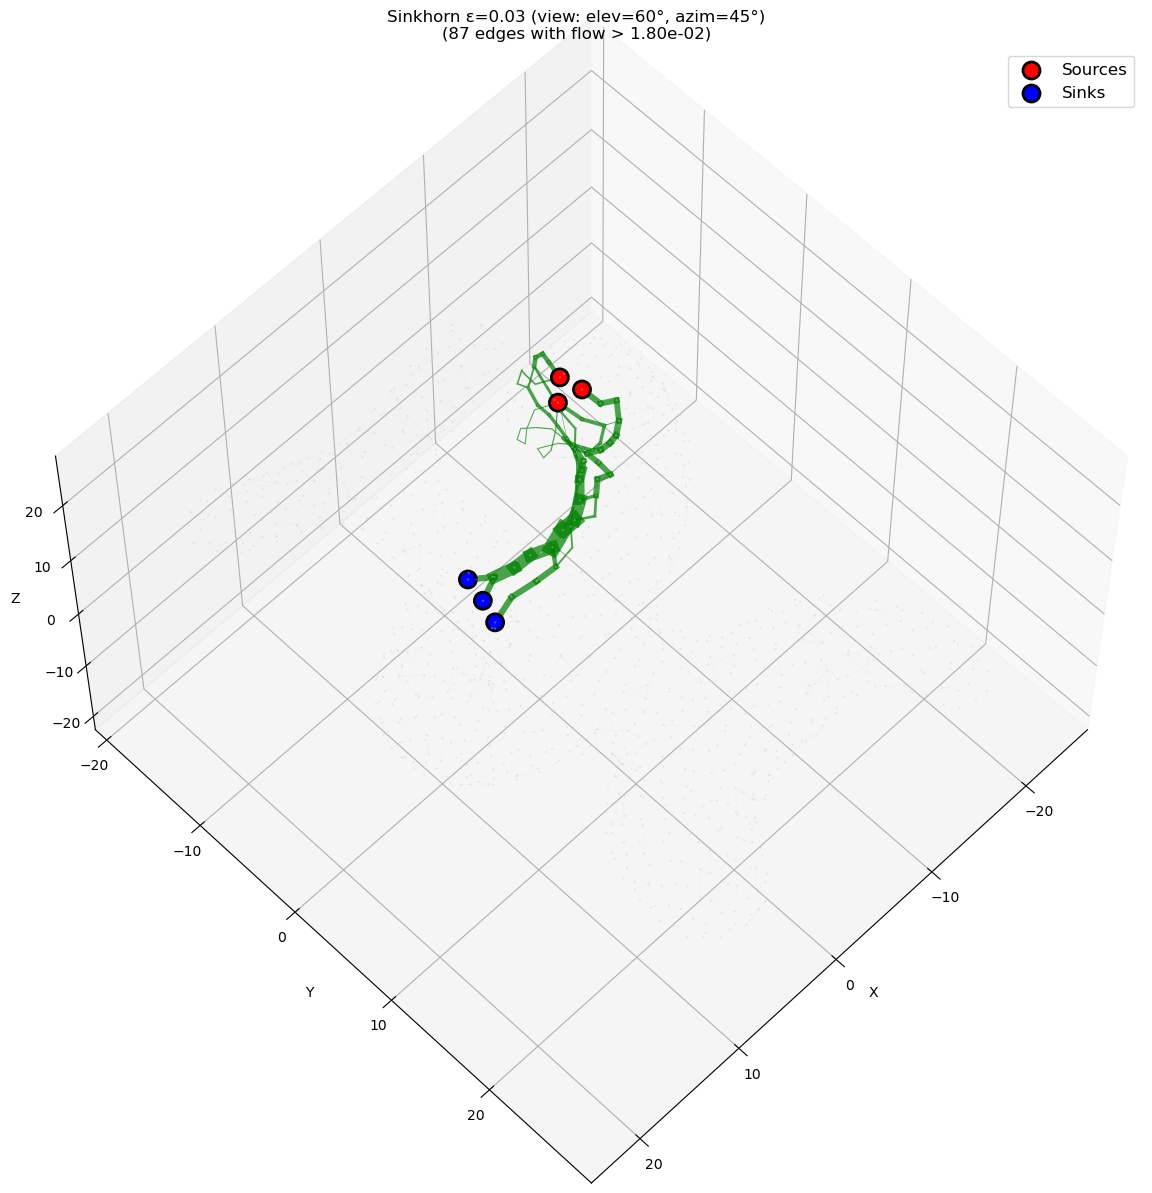

In [18]:
# Multiple viewing angles
angles = [(20, 45), (20, 135), (60, 45)]

for elev, azim in angles:
    print(f"\nViewing angle: elevation={elev}°, azimuth={azim}°")
    
    plot_mesh_with_flow(vertices, faces, F_exact, z,
                        threshold=threshold_exact,
                        title=f"Exact Flow (view: elev={elev}°, azim={azim}°)",
                        flow_color='purple',
                        flow_width_scale=15,
                        elev=elev, azim=azim)
    
    plot_mesh_with_flow(vertices, faces, F_sinkhorn_small_dense, z,
                        threshold=threshold_small,
                        title=f"Sinkhorn ε={epsilon_small} (view: elev={elev}°, azim={azim}°)",
                        flow_color='green',
                        flow_width_scale=12,
                        elev=elev, azim=azim)